In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Load in the data and the umbrella terms with labels that fall under them.

In [5]:
data = pd.read_csv('Data_set/all_compounds-sparse.csv')
labels_in_data = pd.read_excel('Data_set/labels.xlsx')

print(data.shape)
print(labels_in_data)

f = open('Data_set/umbrella_terms.csv', 'r')
lines = f.readlines()

clusters = []

for line in lines:
    line = line.lower()
    line = line.strip()
    line = line.split(',')
    clusters.append(line)

print(clusters)

(13047, 5)
     Unnamed: 0           0
0             0        acid
1             1     alcohol
2             2    aldehyde
3             3  alliaceous
4             4      almond
..          ...         ...
159         159      watery
160         160         wax
161         161       weedy
162         162        wine
163         163        wood

[164 rows x 2 columns]
[['green', 'cucumber', 'radish', 'celery', 'galbanum', 'grass', 'weedy', 'leaf', 'moss'], ['fruity', 'ripe', 'juicy', 'tropical', 'coconut', 'pear', 'pineapple', 'plum', 'apple', 'apricot', 'peach', 'cherry', 'melon', 'fruit', 'berry', 'berry', 'strawberry', 'raspberry', 'grape', 'hawthorn', 'citrus', 'orange', 'grapefruit', 'lemon', 'citrus', 'bergamot', 'orange-blossom', 'blackcurrant', 'banana'], ['flower', 'gardenia', 'rose', 'geranium', 'orris', 'hyacinth', 'violet', 'narcissus', 'mimosa', 'floral', 'white flowers', 'lilac', 'lily', 'jasmine', 'muguet', 'orange-blossom'], ['savory', 'fermented', 'cooked', 'savory', '

Descriptor Count
3     3358
2     2504
1     2287
4     1939
5     1291
6      761
7      373
8      242
9      145
10      74
11      35
12      24
13       9
14       4
16       1
Name: count, dtype: int64


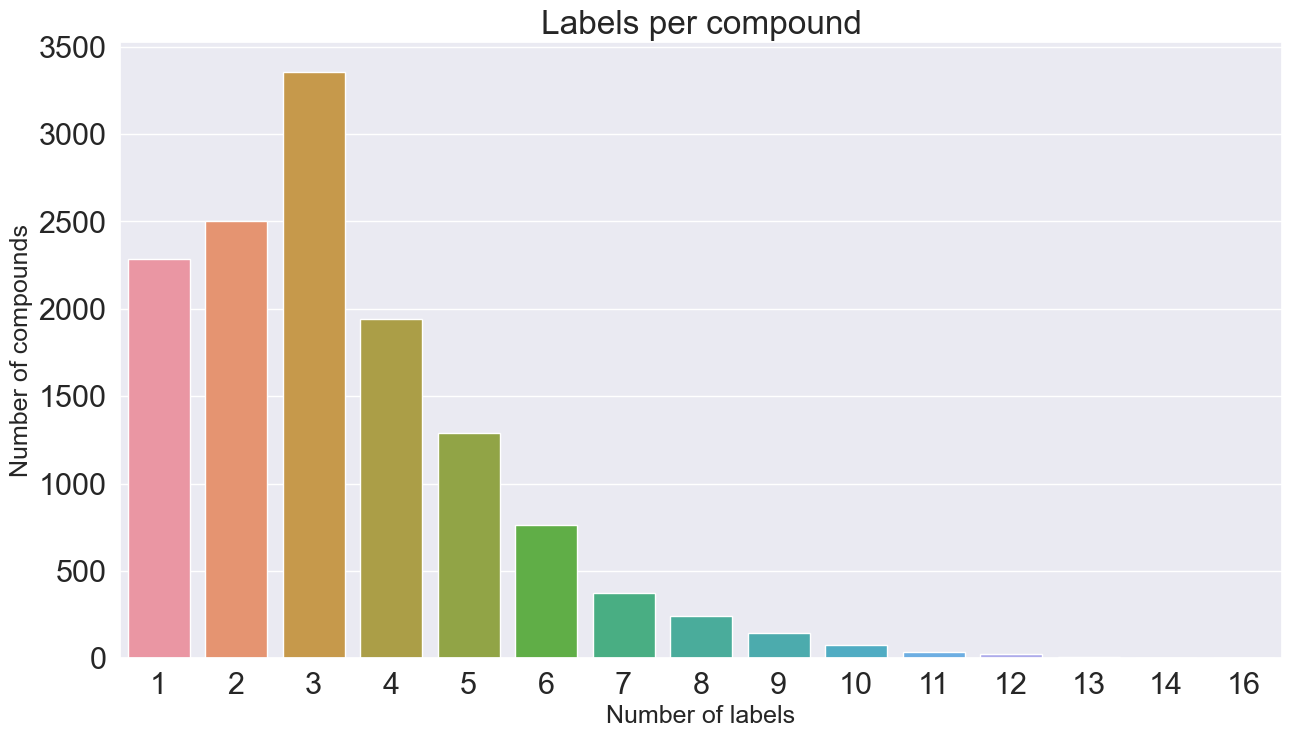

In [20]:
compounds = pd.read_csv('Data_set/all_compounds.csv')

#Plot hist of "Descriptor Count" column
import seaborn as sns

print(compounds['Descriptor Count'].value_counts())

sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(y=compounds['Descriptor Count'].value_counts().values, x=compounds['Descriptor Count'].value_counts().index)
plt.title("Labels per compound", fontsize=24)
plt.ylabel('Number of compounds', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)#adding the text labels
plt.savefig('Images/labels_per_compound-before.png', dpi=300)

Check if all all labels are in both sets. Labels that are missing from the umbrella terms are removed from the data because they couldn't be placed under an umbrella term.

In [21]:
print(labels_in_data[0].tolist())

temp = []
labels_in_data = labels_in_data[0].tolist()

for cluster in clusters:
    temp.extend(cluster)

diff = list(set(labels_in_data) - set(temp))
print(diff)

['acid', 'alcohol', 'aldehyde', 'alliaceous', 'almond', 'amber', 'animal', 'anise', 'apple', 'apricot', 'aromatic', 'balsamic', 'banana', 'beef', 'bergamot', 'berry', 'bitter', 'blackcurrant', 'bland', 'brandy', 'bread', 'brothy', 'brown', 'burnt', 'buttery', 'cabbage', 'camphor', 'caramel', 'cedar', 'celery', 'chamomile', 'characteristic', 'cheese', 'chemical', 'cherry', 'chicken', 'chocolate', 'cinnamon', 'citrus', 'clean', 'clove', 'cocoa', 'coconut', 'coffee', 'cognac', 'cooked', 'cooling', 'cortex', 'coumarin', 'cream', 'cucumber', 'dairy', 'dry', 'earth', 'ester', 'ether', 'fat', 'fermented', 'fish', 'floral', 'fresh', 'fruit', 'gardenia', 'garlic', 'gasoline', 'geranium', 'gourmand', 'grape', 'grapefruit', 'grass', 'green', 'hawthorn', 'hay', 'hazelnut', 'herb', 'honey', 'horseradish', 'hyacinth', 'jam', 'jasmine', 'juicy', 'ketonic', 'lactone', 'lavender', 'leaf', 'leather', 'lemon', 'licorice', 'lilac', 'lily', 'malt', 'marine', 'meat', 'medicine', 'melon', 'menthol', 'metal',

Now replace the labels in the original data with the umbrella labels. If a label is not in clustered then it is removed. 

In [23]:
def check_and_replace(description):
    
    descriptors = description.split(';')
    new_descriptors = []
    
    for descriptor in descriptors:
        for cluster in clusters:
            if descriptor in cluster:
                new_descriptors.append(cluster[0])
            
    return ';'.join(new_descriptors)

def make_unqiue(labels):
   return ';'.join(list(set(labels.split(';'))))
        

data['Descriptors'] = data['Descriptors'].apply(check_and_replace)
data['Descriptors'] = data['Descriptors'].apply(make_unqiue)

data['Descriptors'] = data['Descriptors'].dropna()

#Drop all rows were descriptors are empty
data = data[data['Descriptors'] != '']
print(data.shape)

(11985, 5)


1
6


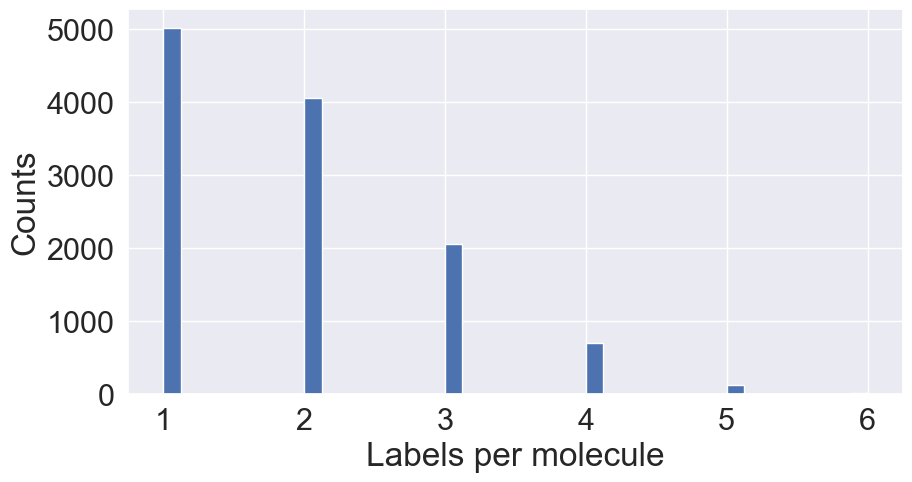

Empty DataFrame
Columns: [CID, IsomericSMILES, Descriptors, MolecularWeight, Descriptor Count]
Index: []


In [24]:
#Count descriptors per compound
data['Descriptor Count'] = data['Descriptors'].apply(lambda x: len(x.split(';')))

# print min and max number of descriptors per compound
print(data['Descriptor Count'].min())
print(data['Descriptor Count'].max())

#Plot distribution of descriptors per compound
plt.figure(figsize=(10, 5))
plt.hist(data['Descriptor Count'], bins=40)
plt.xlabel('Labels per molecule')
plt.ylabel('Counts')
plt.show()

Save to file as sparse and binarized.

In [23]:
#Turn labels into binarized format
from sklearn.preprocessing import MultiLabelBinarizer

#Count nanas
data.to_csv('../Data/all_compounds-umbrella-sparse.csv', index=False)

#Turn descriptors column into lists
print(data.columns)
data['Descriptors'] = data['Descriptors'].apply(lambda x: x.split(';'))

print(data.isna().sum())

mlb = MultiLabelBinarizer(sparse_output=True)
mlb.fit(data['Descriptors'])
print(mlb.classes_, len(mlb.classes_))
data_bin = data.join(pd.DataFrame.sparse.from_spmatrix(mlb.transform(data['Descriptors']), index=data.index, columns=mlb.classes_))
#data_bin.drop(['Descriptors', ''], axis=1, inplace=True)
data_bin.to_csv('../Data/all_compounds-umbrella.csv', index=False)

Index(['CID', 'IsomericSMILES', 'Descriptors', 'MolecularWeight',
       'Descriptor Count'],
      dtype='object')
CID                 0
IsomericSMILES      0
Descriptors         0
MolecularWeight     0
Descriptor Count    0
dtype: int64
['alcohol' 'animal' 'aquatic' 'earthy' 'flower' 'fruity' 'green' 'herbal'
 'savory' 'spices' 'woody'] 11


In [24]:
value_counts = data_bin.iloc[:, 4:].sum(axis=0).sort_values(ascending=False)
print(value_counts)

Descriptor Count    15188
fruity               3251
savory               2379
green                2168
flower               2103
herbal               1809
aquatic              1245
animal                717
alcohol               512
earthy                505
spices                313
woody                 186
dtype: int64


C:\Users\Stijn\AppData\Local\Temp\ipykernel_16252\1624336761.py:35: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sm, label='Frequency of cooccurence')


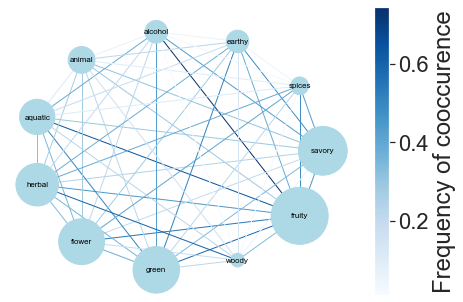

In [25]:
#Use graphviz to create "circo" graph of labels where the cooccurence of labels is the weigth of the edge
import networkx as nx
import matplotlib.pyplot as plt
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout

value_counts = value_counts.drop("Descriptor Count")

#Create graph
G = nx.Graph()

#Add nodes
for label in value_counts.index:
    G.add_node(label, weight=value_counts[label])

#Add edges
for i in range(len(value_counts)):
    for j in range(i+1, len(value_counts)):
        if data_bin[value_counts.index[i]].sum() > 0 and data_bin[value_counts.index[j]].sum() > 0:
            G.add_edge(value_counts.index[i], value_counts.index[j], weight=((data_bin[value_counts.index[i]].dot(data_bin[value_counts.index[j]]) / data_bin[value_counts.index[i]].sum())))
            G.add_edge(value_counts.index[j], value_counts.index[i], weight=((data_bin[value_counts.index[j]].dot(data_bin[value_counts.index[i]]) / data_bin[value_counts.index[j]].sum())))

edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

#Create layout
pos = graphviz_layout(G, prog='circo')

#Draw graph
nx.draw(G, pos, edgelist=edges, node_size=[v for v in value_counts.values], edge_color=weights, width=1, edge_cmap=plt.cm.Blues, with_labels=True, font_size=8, font_color='black', node_color='lightblue')

sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(weights), vmax=max(weights)))
sm._A = []

#Save graph as png
plt.colorbar(sm, label='Frequency of cooccurence')
plt.savefig('../images/umbrella_terms__cooccurencegraph.png', dpi=300)


C:\Users\Stijn\AppData\Local\Temp\ipykernel_16252\593673273.py:31: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sm, label='Percentage of cooccurence (%)')


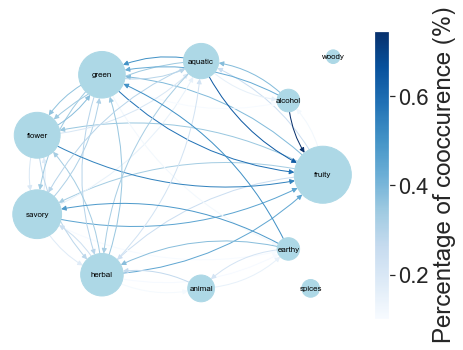

In [26]:
#Create bi-directional graph with the percentage of cooccurence as the weight of the edge
G = nx.DiGraph()

#Add nodes
for label in value_counts.index:
    G.add_node(label, weight=value_counts[label])

#Add edges
for i in range(len(value_counts)):
    for j in range(i+1, len(value_counts)):
        weight1 = (data_bin[value_counts.index[i]].dot(data_bin[value_counts.index[j]]) / data_bin[value_counts.index[i]].sum())
        weight2 = (data_bin[value_counts.index[j]].dot(data_bin[value_counts.index[i]]) / data_bin[value_counts.index[j]].sum())

        if weight1 > 0.1 and weight2 > 0.1:
            G.add_edge(value_counts.index[i], value_counts.index[j], weight=weight1)
            G.add_edge(value_counts.index[j], value_counts.index[i], weight=weight2)

edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

#Create layout
pos = graphviz_layout(G, prog='circo')

#Draw graph
nx.draw(G, pos, edgelist=edges, node_size=[v for v in value_counts.values], edge_color=weights, width=1,\
         edge_cmap=plt.cm.Blues, with_labels=True, font_size=8, font_color='black', node_color='lightblue', connectionstyle="arc3,rad=0.2")

sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(weights), vmax=max(weights)))
sm._A = []

#Save graph as png
plt.colorbar(sm, label='Percentage of cooccurence (%)')
plt.savefig('../images/umbrella_terms__cooccurencegraph_bidirectional.png', dpi=300)